In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from ast import literal_eval
import seaborn as sns
import seaborn.objects as so
from glob import glob
from tqdm import tqdm
import os
import math
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from tqdm import tqdm

import matplotlib.patheffects as path_effects
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc,rcParams
palette = sns.color_palette('deep')
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
line_width=10; alpha_marker = 0.8; alpha_line = 0.7; ms_scatter=100

In [2]:
languages = {'af': {'full': 'Afrikaans'},
             'cs': {'full': 'Czech'},
             'cy': {'full': 'Welsh'},
             'en': {'full': 'English'},
             'fr': {'full': 'French'},
             'ga': {'full': 'Irish'},
             'gu': {'full': 'Gujarati'},
             'hi': {'full': 'Hindi'},
             'is': {'full': 'Icelandic'},
             'it': {'full': 'Italian'},
             'ja': {'full': 'Japanese'},
             'kk': {'full': 'Kazakh'},
             'kn': {'full': 'Kannada'},
             'ms': {'full': 'Malay'},
             'pt': {'full': 'Portuguese'},
             'simple': {'full': 'Simple English'},
             'sk': {'full': 'Slovak'},
             'sw': {'full': 'Swahili'},
             'ur': {'full': 'Urdu'},
             'uz': {'full': 'Uzbek'},
            }

In [5]:
for language in languages:
    languages[language]['total_dirty'] = 0
    languages[language]['missing_context'] = 0
    languages[language]['missing_negative_contexts'] = 0
    languages[language]['bad_target'] = 0
    languages[language]['missing_section'] = 0
    languages[language]['total_clean'] = 0
    languages[language]['total_clean_eval'] = 0 # also excluding the missing section because our model doesn't apply to that
    languages[language]['present_text'] = 0
    languages[language]['missing_mention'] = 0
    languages[language]['missing_sentence'] = 0
    languages[language]['missing_span'] = 0
    languages[language]['missing_section'] = 0
    languages[language]['candidates'] = 0

language_keys = list(languages.keys())
for language in (pbar := tqdm(language_keys)):
    if not os.path.exists(f'/dlabdata1/tsoares/wikidumps/{language}wiki-NS0-20231001/eval/test_data.parquet'):
        del languages[language]
        continue
    good_pages = []
    files = glob(f'/dlabdata1/tsoares/wikidumps/{language}wiki-NS0-20231001/processed_data/good_pages/*.parquet') + \
            glob(f'/dlabdata1/tsoares/wikidumps/{language}wiki-NS0-20231101/processed_data/good_pages/*.parquet')
    for i, file in enumerate(files):
        pbar.set_description(f'{language} - {i} / {len(files)}')
        df = pd.read_parquet(file, columns=['title'])
        good_pages.extend(list(df['title'].values))
    good_pages = set(good_pages)
    languages[language]['good_pages'] = good_pages
    # read test data in chunks
    # only read columns: context, negative_contexts, target_title, missing_category
    # check if file is dir
    if os.path.isdir(f'/dlabdata1/tsoares/wikidumps/{language}wiki-NS0-20231001/eval/test_data.parquet'):
        files = glob(f'/dlabdata1/tsoares/wikidumps/{language}wiki-NS0-20231001/eval/test_data.parquet/*.parquet')
    else:
        files = [f'/dlabdata1/tsoares/wikidumps/{language}wiki-NS0-20231001/eval/test_data.parquet']
    for file in files:
        parquet_file = pq.ParquetFile(file)
        num_rows = parquet_file.metadata.num_rows
        for batch in parquet_file.iter_batches(batch_size=10_000):
            pbar.set_description(f'{language} - {languages[language]["total_dirty"]} / {num_rows}')
            df = batch.to_pandas()
            
            languages[language]['total_dirty'] += len(df)
            
            no_context = df['context'] == ''
            languages[language]['missing_context'] += no_context.sum()
            
            no_neg_contexts = df['negative_contexts'] == '[]'
            languages[language]['missing_negative_contexts'] += no_neg_contexts.sum()
            
            bad_target = ~df['target_title'].isin(languages[language]['good_pages'])
            languages[language]['bad_target'] += bad_target.sum()

            df_clean = df[~no_context & ~no_neg_contexts & ~bad_target]
            languages[language]['total_clean'] += len(df_clean)
            languages[language]['total_clean_eval'] += len(df_clean[df_clean['missing_category'] != 'missing_section'])
            
            # find the value counts for column "missing category"
            # include NA values
            categories = df_clean['missing_category'].value_counts(dropna=False)
            languages[language]['present_text'] += categories[None] if None in categories.index else 0
            languages[language]['missing_mention'] += categories['missing_mention'] if 'missing_mention' in categories.index else 0
            languages[language]['missing_sentence'] += categories['missing_sentence'] if 'missing_sentence' in categories.index else 0
            languages[language]['missing_span'] += categories['missing_span'] if 'missing_span' in categories.index else 0
            languages[language]['missing_section'] += categories['missing_section'] if 'missing_section' in categories.index else 0
            languages[language]['candidates'] += df_clean['negative_contexts'].reset_index(drop=True).apply(lambda x: x.count("'context'") + 1).mean()

    languages[language]['present_text'] /= languages[language]['total_clean'] / 100
    languages[language]['missing_mention'] /= languages[language]['total_clean'] / 100
    languages[language]['missing_sentence'] /= languages[language]['total_clean'] / 100
    languages[language]['missing_span'] /= languages[language]['total_clean'] / 100
    languages[language]['missing_section'] /= languages[language]['total_clean'] / 100

uz - 0 / 5942: 100%|██████████| 20/20 [20:18<00:00, 60.95s/it]         


## Plots

In [6]:
for lang in languages:
    if languages[lang]['total_clean'] < 1_000:
        languages[lang]['total_text'] = languages[lang]['total_clean']
    elif languages[lang]['total_clean'] < 1_000_000:
        languages[lang]['total_text'] = f'{round(languages[lang]["total_clean"] / 1_000):d}K'
    else:
        languages[lang]['total_text'] = f'{round(languages[lang]["total_clean"] / 1_000_000):d}M'

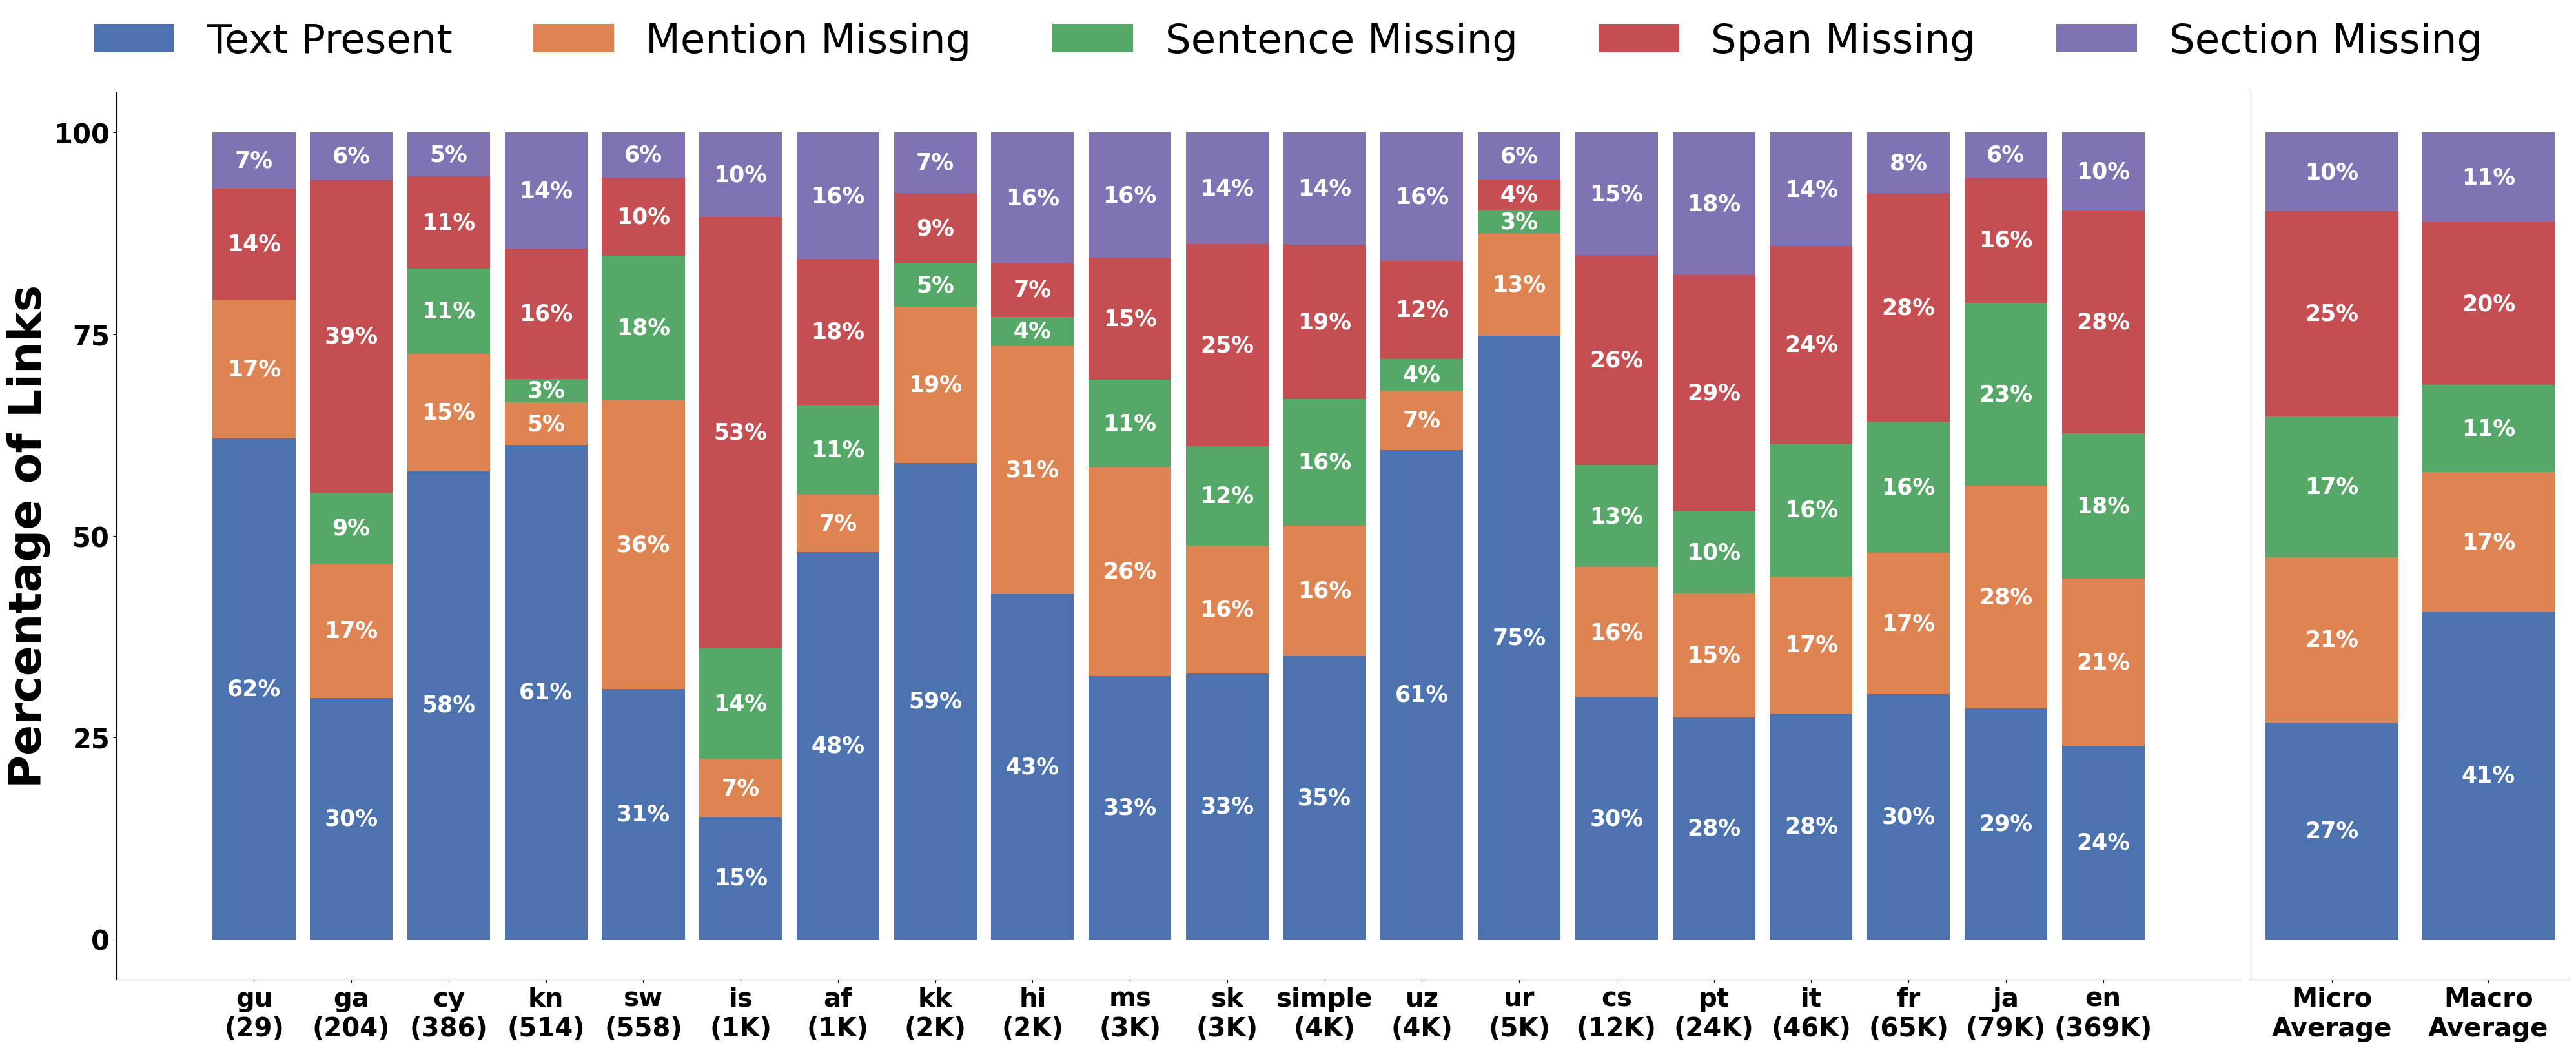

In [8]:
# matplotlib stacked bar plot
# create a 1x4 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(40, 15), width_ratios=[20, 3])

# set global title
# fig.suptitle('Link Insertion Strategy Distribution (Oct 2023 $\\rightarrow$ Nov 2023)', fontsize=60, y=1.1, weight='bold')
# set y label for all subplots
for ax in axs:
    # ax.set_xlabel('Language', fontsize=20)
    ax.set_ylim(-5, 105)
    ax.tick_params(axis='y', which='major', labelsize=30)
    # set to bold
    ax.tick_params(axis='x', which='major', labelsize=30)
axs[0].set_ylabel('Percentage of Links', fontsize=50, weight='bold')
languages = {k: v for k, v in sorted(languages.items(), key=lambda item: item[1]['total_clean'], reverse=False)}
labels = [f"{language}\n({languages[language]['total_text']})" for language in languages]
labels.append('Micro\nAverage')
labels.append('Macro\nAverage')
labels = [labels[0:20], [labels[20],labels[21]]]
for i, ax in enumerate(axs):
    ax.set_xticks(np.arange(len(labels[i])))
    ax.set_xticklabels(labels[i], rotation=0, fontsize=29, weight='bold')
    ax.set_yticks([])
axs[0].set_yticks(np.arange(0, 101, 25))
axs[0].set_yticklabels(np.arange(0, 101, 25), fontsize=30, weight='bold')

present_text = []
missing_mention = []
missing_sentence = []
missing_span = []
missing_section = []

total = {'present_text': 0,
         'missing_mention': 0,
         'missing_sentence': 0,
         'missing_span': 0,
         'missing_section': 0,
         'total': 0}
for language in languages:
    present_text.append(languages[language]['present_text'])
    missing_mention.append(languages[language]['missing_mention'])
    missing_sentence.append(languages[language]['missing_sentence'])
    missing_span.append(languages[language]['missing_span'])
    missing_section.append(languages[language]['missing_section'])
    total['present_text'] += languages[language]['present_text'] * languages[language]['total_clean'] / 100
    total['missing_mention'] += languages[language]['missing_mention'] * languages[language]['total_clean'] / 100
    total['missing_sentence'] += languages[language]['missing_sentence'] * languages[language]['total_clean'] / 100
    total['missing_span'] += languages[language]['missing_span'] * languages[language]['total_clean'] / 100
    total['missing_section'] += languages[language]['missing_section'] * languages[language]['total_clean'] / 100
    total['total'] += languages[language]['total_clean']

# append micro average results
present_text.append(total['present_text'] / total['total'] * 100)
missing_mention.append(total['missing_mention'] / total['total'] * 100)
missing_sentence.append(total['missing_sentence'] / total['total'] * 100)
missing_span.append(total['missing_span'] / total['total'] * 100)
missing_section.append(total['missing_section'] / total['total'] * 100)
# append macro average results
present_text.append(sum(present_text[:-1]) / len(present_text[:-1]))
missing_mention.append(sum(missing_mention[:-1]) / len(missing_mention[:-1]))
missing_sentence.append(sum(missing_sentence[:-1]) / len(missing_sentence[:-1]))
missing_span.append(sum(missing_span[:-1]) / len(missing_span[:-1]))
missing_section.append(sum(missing_section[:-1]) / len(missing_section[:-1]))

# split into 4 subplots
present_text = [present_text[0:20], [present_text[20], present_text[21]]]
missing_mention = [missing_mention[0:20], [missing_mention[20], missing_mention[21]]]
missing_sentence = [missing_sentence[0:20], [missing_sentence[20], missing_sentence[21]]]
missing_span = [missing_span[0:20], [missing_span[20], missing_span[21]]]
missing_section = [missing_section[0:20], [missing_section[20], missing_section[21]]]

bottom = [np.zeros(len(p)) for p in present_text]
present_text = [np.array(p) for p in present_text]
missing_mention = [np.array(p) for p in missing_mention]
missing_sentence = [np.array(p) for p in missing_sentence]
missing_span = [np.array(p) for p in missing_span]
missing_section = [np.array(p) for p in missing_section]

# use a colorblind friendly palette
for i, ax in enumerate(axs):
    ax.bar(np.arange(len(present_text[i])), present_text[i], label='Text Present', bottom=bottom[i], width=0.85, color=sns.color_palette('deep')[0])
    bottom[i] += present_text[i]
    ax.bar(np.arange(len(present_text[i])), missing_mention[i], label='Mention Missing', bottom=bottom[i], width=0.85, color=sns.color_palette('deep')[1])
    bottom[i] += missing_mention[i]
    ax.bar(np.arange(len(present_text[i])), missing_sentence[i], label='Sentence Missing', bottom=bottom[i], width=0.85, color=sns.color_palette('deep')[2])
    bottom[i] += missing_sentence[i]
    ax.bar(np.arange(len(present_text[i])), missing_span[i], label='Span Missing', bottom=bottom[i], width=0.85, color=sns.color_palette('deep')[3])
    bottom[i] += missing_span[i]
    ax.bar(np.arange(len(present_text[i])), missing_section[i], label='Section Missing', bottom=bottom[i], width=0.85, color=sns.color_palette('deep')[4])
    bottom[i] += missing_section[i]

# add legend to figure
# only show the legend for the first subplot
# make the legend horizontal and centered
# axs[0].legend(bbox_to_anchor=(2, 1.1), ncol=5, fontsize=20)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='upper center', ncol=5, fontsize=45, bbox_to_anchor=(0.5, 1.1), frameon=False)
# reverse the order of the legend
# handles, labels = axs[0].get_legend_handles_labels()
# axs[0].legend(handles[::-1], labels[::-1],bbox_to_anchor=(1, 1.07), ncol=5, fontsize=18)


# add labels inside each bar
for row in range(len(axs)):
    for i, v in enumerate(present_text[row]):
        if v > 0:
            axs[row].text(i, v/2, f'{v:.0f}%', color='white', ha='center', va='center', fontweight='bold', fontsize=25)
    for i, v in enumerate(missing_mention[row]):
        if v > 0:
            axs[row].text(i, present_text[row][i]+v/2, f'{v:.0f}%', color='white', ha='center', va='center', fontweight='bold', fontsize=25)
    for i, v in enumerate(missing_sentence[row]):
        if v > 0:
            axs[row].text(i, present_text[row][i]+missing_mention[row][i]+v/2, f'{v:.0f}%', color='white', ha='center', va='center', fontweight='bold', fontsize=25)
    for i, v in enumerate(missing_span[row]):
        if v > 0:
            axs[row].text(i, present_text[row][i]+missing_mention[row][i]+missing_sentence[row][i]+v/2, f'{v:.0f}%', color='white', ha='center', va='center', fontweight='bold', fontsize=25)
    for i, v in enumerate(missing_section[row]):
        if v > 0:
            axs[row].text(i, present_text[row][i]+missing_mention[row][i]+missing_sentence[row][i]+missing_span[row][i]+v/2, f'{v:.0f}%', color='white', ha='center', va='center', fontweight='bold', fontsize=25)
plt.tight_layout()
plt.savefig('link_insertion_strategy_distribution.pdf', bbox_inches='tight')
plt.show()

<BarContainer object of 21 artists>

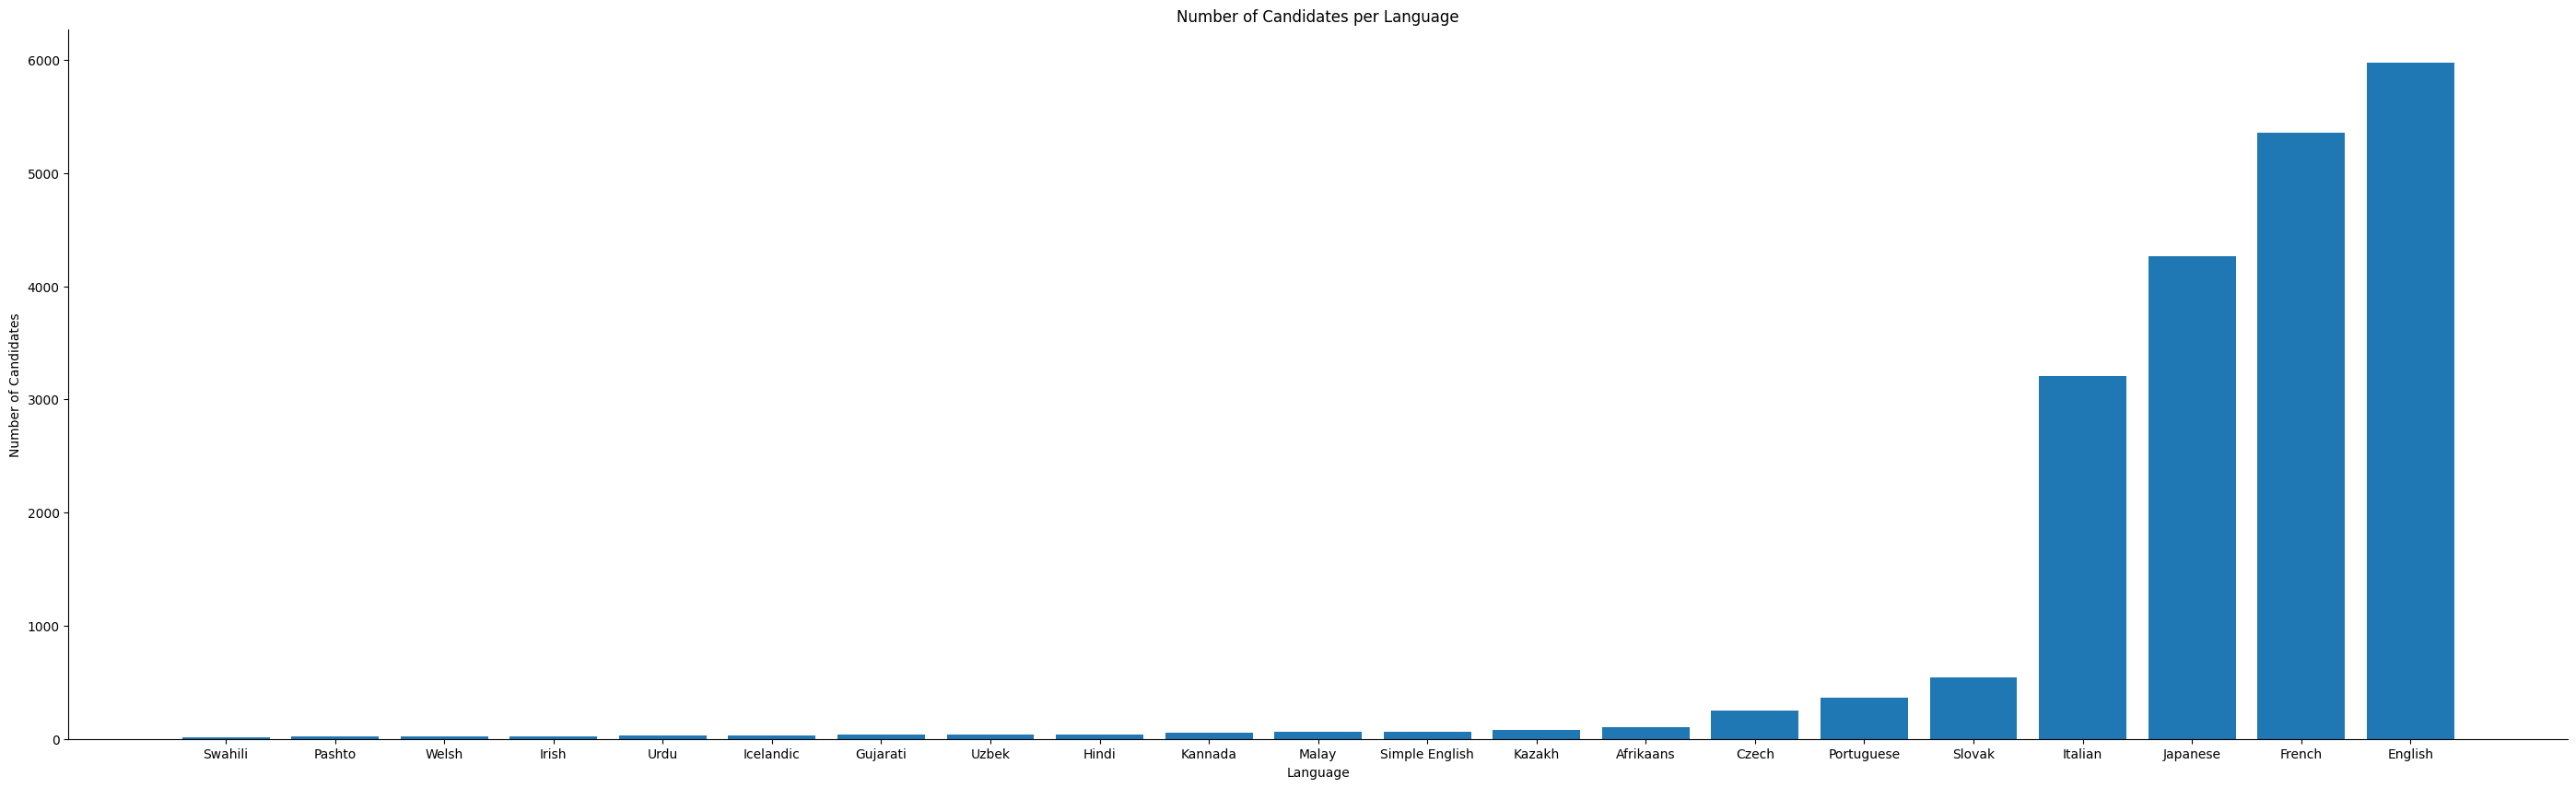

In [6]:
# plot a bar chart of the number of negative contexts per language
fig, ax = plt.subplots(figsize=(35, 10))
ax.set_title('Number of Candidates per Language')
ax.set_ylabel('Number of Candidates')
ax.set_xlabel('Language')
# sort the languages by number of candidates
languages = {k: v for k, v in sorted(languages.items(), key=lambda item: item[1]['candidates'])}
ax.set_xticks(np.arange(len(languages)))
ax.set_xticklabels([languages[language]['full'] for language in languages], rotation=0)
ax.bar(np.arange(len(languages)), [languages[language]['candidates'] for language in languages])


# Full analysis

In [10]:
files = glob('/dlabdata1/tsoares/wikidumps/*wiki-NS0-20231001/eval/test_data.parquet')
# find the list of all languages
languages = [file.split('/')[-3][:-17] for file in files]
languages.sort()
len(languages), languages

(110,
 ['af',
  'am',
  'an',
  'ar',
  'ary',
  'as',
  'ast',
  'az',
  'azb',
  'ba',
  'bar',
  'be',
  'bg',
  'br',
  'bs',
  'ca',
  'ce',
  'cs',
  'cv',
  'cy',
  'da',
  'de',
  'el',
  'en',
  'eo',
  'es',
  'et',
  'eu',
  'fa',
  'fi',
  'fr',
  'fy',
  'ga',
  'gd',
  'gl',
  'gu',
  'ha',
  'he',
  'hi',
  'hr',
  'hu',
  'hy',
  'id',
  'io',
  'is',
  'it',
  'ja',
  'jv',
  'ka',
  'kk',
  'km',
  'kn',
  'ko',
  'ku',
  'la',
  'lb',
  'lmo',
  'lo',
  'lt',
  'lv',
  'mg',
  'min',
  'mk',
  'mn',
  'mr',
  'ms',
  'nds-nl',
  'ne',
  'nl',
  'no',
  'oc',
  'om',
  'pa',
  'pl',
  'pms',
  'ps',
  'pt',
  'ro',
  'ru',
  'sa',
  'scn',
  'sco',
  'sd',
  'sh',
  'si',
  'simple',
  'sk',
  'sl',
  'so',
  'sq',
  'sr',
  'su',
  'sv',
  'sw',
  'ta',
  'te',
  'tg',
  'tl',
  'tr',
  'tt',
  'ug',
  'uk',
  'ur',
  'uz',
  'vi',
  'vo',
  'war',
  'xh',
  'yi',
  'zh'])

In [3]:
stats = {lang: {'text_present': 0, 'missing_mention': 0, 'missing_sentence': 0,
                'missing_span': 0, 'missing_section': 0} for lang in languages}

for language in (pbar := tqdm(languages)):
    if not os.path.exists(f'/dlabdata1/tsoares/wikidumps/{language}wiki-NS0-20231001/eval/test_data.parquet'):
        continue
    good_pages = []
    files = glob(f'/dlabdata1/tsoares/wikidumps/{language}wiki-NS0-20231001/processed_data/good_pages/*.parquet') + \
        glob(
            f'/dlabdata1/tsoares/wikidumps/{language}wiki-NS0-20231101/processed_data/good_pages/*.parquet')
    for i, file in enumerate(files):
        pbar.set_description(f'{language} - {i} / {len(files)}')
        try:
            df = pd.read_parquet(file, columns=['title'])
        except:
            pass
        good_pages.extend(list(df['title'].values))
    good_pages = set(good_pages)
    # read test data in chunks
    # only read columns: context, negative_contexts, target_title, missing_category
    parquet_file = pq.ParquetFile(
        f'/dlabdata1/tsoares/wikidumps/{language}wiki-NS0-20231001/eval/test_data.parquet')
    num_rows = parquet_file.metadata.num_rows
    total = 0
    for batch in parquet_file.iter_batches(batch_size=25_000):
        pbar.set_description(
            f'{language} - {total} / {num_rows}')
        df = batch.to_pandas()
        total += len(df)
        no_context = df['context'] == ''
        no_neg_contexts = df['negative_contexts'] == '[]'
        bad_target = ~df['target_title'].isin(good_pages)

        df_clean = df[~no_context & ~no_neg_contexts & ~bad_target]

        # find the value counts for column "missing category"
        # include NA values
        categories = df_clean['missing_category'].value_counts(dropna=False)
        stats[language]['text_present'] += categories[None] if None in categories.index else 0
        stats[language]['missing_mention'] += categories['missing_mention'] if 'missing_mention' in categories.index else 0
        stats[language]['missing_sentence'] += categories['missing_sentence'] if 'missing_sentence' in categories.index else 0
        stats[language]['missing_span'] += categories['missing_span'] if 'missing_span' in categories.index else 0
        stats[language]['missing_section'] += categories['missing_section'] if 'missing_section' in categories.index else 0

zh - 25000 / 49689: 100%|██████████| 110/110 [31:46<00:00, 17.33s/it]    


In [4]:
stats_df = pd.DataFrame(stats).T
stats_df.to_csv('stats.csv')

In [5]:
stats = [(k, v) for k, v in stats.items()]

In [6]:
stats = sorted(stats, key = lambda x: sum(x[1].values()), reverse=True)

In [7]:
same_line = True
for stat in stats:
    print(stat[0] + ' & ', end='')
    total_links = sum(stat[1].values())
    if total_links == 0:
        print('0 & 0 & 0 & 0 & 0 & 0', end='')
    else:
        for key in ['text_present', 'missing_mention', 'missing_sentence', 'missing_span', 'missing_section']:
            print(f'{stat[1][key]} ({stat[1][key] / total_links * 100:.1f} \\%) & ', end='')
        print(total_links, end='')
    if same_line:
        print(' & ', end='')
        same_line = False
    else:
        print(' \\\\')
        same_line = True

en & 41492 (23.9 \%) & 33679 (19.4 \%) & 32583 (18.7 \%) & 48325 (27.8 \%) & 17808 (10.2 \%) & 173887 & de & 24331 (25.8 \%) & 15327 (16.2 \%) & 17937 (19.0 \%) & 27367 (29.0 \%) & 9363 (9.9 \%) & 94325 \\
ja & 22607 (28.6 \%) & 21860 (27.7 \%) & 17935 (22.7 \%) & 12282 (15.5 \%) & 4374 (5.5 \%) & 79058 & es & 20113 (30.3 \%) & 19183 (28.9 \%) & 5899 (8.9 \%) & 13763 (20.7 \%) & 7419 (11.2 \%) & 66377 \\
fr & 19626 (30.4 \%) & 11290 (17.5 \%) & 10479 (16.2 \%) & 18293 (28.3 \%) & 4851 (7.5 \%) & 64539 & it & 12783 (28.0 \%) & 7754 (17.0 \%) & 7516 (16.5 \%) & 11158 (24.4 \%) & 6430 (14.1 \%) & 45641 \\
he & 13190 (35.9 \%) & 5837 (15.9 \%) & 5087 (13.8 \%) & 9014 (24.5 \%) & 3653 (9.9 \%) & 36781 & ru & 11694 (34.5 \%) & 5406 (16.0 \%) & 4627 (13.7 \%) & 9266 (27.4 \%) & 2860 (8.4 \%) & 33853 \\
zh & 8630 (30.6 \%) & 7095 (25.2 \%) & 5329 (18.9 \%) & 5531 (19.6 \%) & 1624 (5.8 \%) & 28209 & pl & 7488 (27.4 \%) & 3956 (14.5 \%) & 4455 (16.3 \%) & 7525 (27.6 \%) & 3873 (14.2 \%) & 27297 

In [10]:
micro_avg = {'text_present': 0, 'missing_mention': 0, 'missing_sentence': 0, 'missing_span': 0, 'missing_section': 0, 'total': 0}
for stat in stats:
    for key in ['text_present', 'missing_mention', 'missing_sentence', 'missing_span', 'missing_section']:
        micro_avg[key] += stat[1][key]
    micro_avg['total'] += sum(stat[1].values())
for key in ['text_present', 'missing_mention', 'missing_sentence', 'missing_span', 'missing_section', 'total']:
    micro_avg[key] /= len(stats)
for key in micro_avg:
    print(key, micro_avg[key] * len(stats), micro_avg[key] / micro_avg['total'] * 100)

text_present 287754.0 29.39985287506641
missing_mention 185024.0 18.903919244758676
missing_sentence 150679.0 15.394887408557768
missing_span 248837.99999999997 25.423801544811802
missing_section 106465.0 10.877538926805345
total 978760.0 100.0


In [9]:
macro_avg = {'text_present': 0, 'missing_mention': 0, 'missing_sentence': 0, 'missing_span': 0, 'missing_section': 0, 'total': 0}
for stat in stats:
    for key in ['text_present', 'missing_mention', 'missing_sentence', 'missing_span', 'missing_section']:
        if sum(stat[1].values()) == 0:
            macro_avg[key] += 0
        else:
            macro_avg[key] += stat[1][key] / sum(stat[1].values()) * 100
    macro_avg['total'] += 100
for key in ['text_present', 'missing_mention', 'missing_sentence', 'missing_span', 'missing_section', 'total']:
    macro_avg[key] /= len(stats)
for key in macro_avg:
    print(key, macro_avg[key])

text_present 34.13564595609687
missing_mention 18.290501742412722
missing_sentence 10.885272904013837
missing_span 21.221762134781827
missing_section 11.830453626331119
total 100.0


# Table with number of pages, existing links and added links for all languages

In [3]:
files = glob('/dlabdata1/tsoares/wikidumps/*wiki-NS0-20231001/eval/test_data.parquet')
# find the list of all languages
languages = [file.split('/')[-3][:-17] for file in files]
languages.sort()
len(languages), languages

(110,
 ['af',
  'am',
  'an',
  'ar',
  'ary',
  'as',
  'ast',
  'az',
  'azb',
  'ba',
  'bar',
  'be',
  'bg',
  'br',
  'bs',
  'ca',
  'ce',
  'cs',
  'cv',
  'cy',
  'da',
  'de',
  'el',
  'en',
  'eo',
  'es',
  'et',
  'eu',
  'fa',
  'fi',
  'fr',
  'fy',
  'ga',
  'gd',
  'gl',
  'gu',
  'ha',
  'he',
  'hi',
  'hr',
  'hu',
  'hy',
  'id',
  'io',
  'is',
  'it',
  'ja',
  'jv',
  'ka',
  'kk',
  'km',
  'kn',
  'ko',
  'ku',
  'la',
  'lb',
  'lmo',
  'lo',
  'lt',
  'lv',
  'mg',
  'min',
  'mk',
  'mn',
  'mr',
  'ms',
  'nds-nl',
  'ne',
  'nl',
  'no',
  'oc',
  'om',
  'pa',
  'pl',
  'pms',
  'ps',
  'pt',
  'ro',
  'ru',
  'sa',
  'scn',
  'sco',
  'sd',
  'sh',
  'si',
  'simple',
  'sk',
  'sl',
  'so',
  'sq',
  'sr',
  'su',
  'sv',
  'sw',
  'ta',
  'te',
  'tg',
  'tl',
  'tr',
  'tt',
  'ug',
  'uk',
  'ur',
  'uz',
  'vi',
  'vo',
  'war',
  'xh',
  'yi',
  'zh'])

In [4]:
stats = {lang: {'number_articles': 0,
                'existing_links': 0,
                'added_links': 0} for lang in languages}

In [5]:
for language in (pbar := tqdm(languages)):
    # find good pages
    good_pages = []
    files = glob(f'/dlabdata1/tsoares/wikidumps/{language}wiki-NS0-20231001/processed_data/good_pages/*.parquet') + \
            glob(f'/dlabdata1/tsoares/wikidumps/{language}wiki-NS0-20231101/processed_data/good_pages/*.parquet')
    for i, file in enumerate(files):
        pbar.set_description(f'{language} - {i} / {len(files)}')
        try:
            df = pd.read_parquet(file, columns=['title'])
        except:
            continue
        good_pages.extend(list(df['title'].values))
    good_pages = set(good_pages)
    stats[language]['number_articles'] = len(good_pages)
    
    # find good links
    good_links = 0
    files = glob(f'/dlabdata1/tsoares/wikidumps/{language}wiki-NS0-20231001/processed_data/good_links/*.parquet')
    for i, file in enumerate(files):
        pbar.set_description(f'{language} - {i} / {len(files)}')
        df = pd.read_parquet(file, columns=['target_title'])
        good_links += len(df)
    stats[language]['existing_links'] = good_links
    
    # read test data in chunks
    # only read columns: context, negative_contexts, target_title
    # check if file is dir
    if os.path.isdir(f'/dlabdata1/tsoares/wikidumps/{language}wiki-NS0-20231001/eval/test_data.parquet'):
        files = glob(f'/dlabdata1/tsoares/wikidumps/{language}wiki-NS0-20231001/eval/test_data.parquet/*.parquet')
    else:
        files = [f'/dlabdata1/tsoares/wikidumps/{language}wiki-NS0-20231001/eval/test_data.parquet']
    if len(files) == 0:
        del stats[language]
    for file in files:
        parquet_file = pq.ParquetFile(file)
        num_rows = parquet_file.metadata.num_rows
        for batch in parquet_file.iter_batches(batch_size=10_000):
            pbar.set_description(f'{language} - {stats[language]["added_links"]} / {num_rows}')
            df = batch.to_pandas()
            no_context = df['context'] == ''
            no_neg_contexts = df['negative_contexts'] == '[]'
            bad_target = ~df['target_title'].isin(good_pages)
            df_clean = df[~no_context & ~no_neg_contexts & ~bad_target]
            stats[language]['added_links'] += len(df_clean)

zh - 24128 / 49689: 100%|██████████| 110/110 [32:22<00:00, 17.66s/it]    


In [17]:
list_languages = [{'number_articles': stats[lang]['number_articles'],
                   'existing_links': stats[lang]['existing_links'],
                   'added_links': stats[lang]['added_links'],
                   'lang': lang} for lang in stats]
list_languages = sorted(list_languages, key=lambda x: x['number_articles'], reverse=True)

In [18]:
df_languages = pd.read_html('https://meta.wikimedia.org/wiki/List_of_Wikipedias')[0]
for i in range(len(list_languages)):
    list_languages[i]['full_name'] = df_languages[df_languages['Wiki'] == list_languages[i]['lang']]['Language'].values[0]
list_languages

[{'number_articles': 6729880,
  'existing_links': 166716888,
  'added_links': 368964,
  'lang': 'en',
  'full_name': 'English'},
 {'number_articles': 2836835,
  'existing_links': 78324780,
  'added_links': 94325,
  'lang': 'de',
  'full_name': 'German'},
 {'number_articles': 2570598,
  'existing_links': 29989592,
  'added_links': 10729,
  'lang': 'sv',
  'full_name': 'Swedish'},
 {'number_articles': 2524278,
  'existing_links': 85133988,
  'added_links': 64539,
  'lang': 'fr',
  'full_name': 'French'},
 {'number_articles': 2134209,
  'existing_links': 24706918,
  'added_links': 23697,
  'lang': 'nl',
  'full_name': 'Dutch'},
 {'number_articles': 1926248,
  'existing_links': 47645856,
  'added_links': 33853,
  'lang': 'ru',
  'full_name': 'Russian'},
 {'number_articles': 1838825,
  'existing_links': 47947535,
  'added_links': 66377,
  'lang': 'es',
  'full_name': 'Spanish'},
 {'number_articles': 1781154,
  'existing_links': 51190077,
  'added_links': 45641,
  'lang': 'it',
  'full_name'

In [19]:
# print results in LaTeX table
new_line = False
print(" & & Articles & Existing Links & Added Links & & Articles & Existing Links & Added Links \\\\\\hline")
for elem in list_languages:
    # reduce representation of number of articles
    if elem['number_articles'] >= 1_000_000:
        number_articles = f'{elem["number_articles"] // 100_000 / 10}M'
    elif elem['number_articles'] >= 100_000:
        number_articles = f'{elem["number_articles"] // 1_000}K'
    elif elem['number_articles'] >= 1_000:
        number_articles = f'{elem["number_articles"] // 100 / 10}K'
    else:
        number_articles = f'{elem["number_articles"]}'
    
    # reduce representation of existing links
    if elem['existing_links'] >= 100_000_000:
        existing_links = f'{elem["existing_links"] // 1_000_000}M'
    elif elem['existing_links'] >= 1_000_000:
        existing_links = f'{elem["existing_links"] // 100_000 / 10}M'
    elif elem['existing_links'] >= 100_000:
        existing_links = f'{elem["existing_links"] // 1_000}K'
    elif elem['existing_links'] >= 1_000:
        existing_links = f'{elem["existing_links"] // 100 / 10}K'
    else:
        existing_links = f'{elem["existing_links"]}'
    
    # reduce representation of added links
    if elem['added_links'] >= 1_000_000:
        added_links = f'{elem["added_links"] // 100_000 / 10}M'
    elif elem['added_links'] >= 100_000:
        added_links = f'{elem["added_links"] // 1_000}K'
    elif elem['added_links'] >= 1_000:
        added_links = f'{elem["added_links"] // 100 / 10}K'
    else:
        added_links = f'{elem["added_links"]}'
    
    print(f"{elem['lang']} & {elem['full_name']} & {number_articles} & {existing_links} & {added_links}", end='')
    if new_line:
        print('\\\\')
    else:
        print(' & ', end='')
    new_line = not new_line

 & & Articles & Existing Links & Added Links & & Articles & Existing Links & Added Links \
en & English & 6.7M & 166M & 368K & de & German & 2.8M & 78.3M & 94.3K\\
sv & Swedish & 2.5M & 29.9M & 10.7K & fr & French & 2.5M & 85.1M & 64.5K\\
nl & Dutch & 2.1M & 24.7M & 23.6K & ru & Russian & 1.9M & 47.6M & 33.8K\\
es & Spanish & 1.8M & 47.9M & 66.3K & it & Italian & 1.7M & 51.1M & 45.6K\\
pl & Polish & 1.5M & 30.1M & 27.2K & ja & Japanese & 1.3M & 60.6M & 79.0K\\
zh & Chinese & 1.3M & 23.1M & 28.2K & vi & Vietnamese & 1.2M & 10.3M & 11.9K\\
ar & Arabic & 1.2M & 16.3M & 17.8K & pt & Portuguese & 1.1M & 21.9M & 24.2K\\
fa & Persian & 971K & 9.5M & 18.1K & ca & Catalan & 732K & 14.6M & 18.4K\\
sr & Serbian & 671K & 8.3M & 5.4K & id & Indonesian & 650K & 8.5M & 13.7K\\
ko & Korean & 634K & 11.2M & 21.3K & no & Norwegian & 611K & 11.3M & 7.2K\\
ce & Chechen & 599K & 3.0M & 48 & fi & Finnish & 554K & 9.7M & 13.7K\\
cs & Czech & 531K & 14.4M & 12.3K & tr & Turkish & 531K & 6.7M & 14.9K\\
hu & Hu

# Paper plots

## All languages for 10/23 -> 11/23

In [4]:
files = glob('/dlabdata1/tsoares/wikidumps/*wiki-NS0-20231001/eval/test_data.parquet')
# find the list of all languages
languages = [file.split('/')[-3][:-17] for file in files]
languages.sort()
languages = {lang: {} for lang in languages}
len(languages)

106

In [5]:
for language in languages:
    languages[language]['total_dirty'] = 0
    languages[language]['missing_context'] = 0
    languages[language]['missing_negative_contexts'] = 0
    languages[language]['bad_target'] = 0
    languages[language]['missing_section'] = 0
    languages[language]['total_clean'] = 0
    languages[language]['total_clean_eval'] = 0 # also excluding the missing section because our model doesn't apply to that
    languages[language]['present_text'] = 0
    languages[language]['missing_mention'] = 0
    languages[language]['missing_sentence'] = 0
    languages[language]['missing_span'] = 0
    languages[language]['missing_section'] = 0
    languages[language]['candidates'] = []

language_keys = list(languages.keys())
for language in (pbar := tqdm(language_keys)):
    if not os.path.exists(f'/dlabdata1/tsoares/wikidumps/{language}wiki-NS0-20231001/eval/test_data.parquet'):
        del languages[language]
        continue
    good_pages = []
    files = glob(f'/dlabdata1/tsoares/wikidumps/{language}wiki-NS0-20231001/processed_data/good_pages/*.parquet') + \
            glob(f'/dlabdata1/tsoares/wikidumps/{language}wiki-NS0-20231101/processed_data/good_pages/*.parquet')
    for i, file in enumerate(files):
        pbar.set_description(f'{language} - {i} / {len(files)}')
        try:
            df = pd.read_parquet(file, columns=['title'])
            good_pages.extend(list(df['title'].values))
        except:
            pass
    good_pages = set(good_pages)
    languages[language]['good_pages'] = good_pages
    # read test data in chunks
    # only read columns: context, negative_contexts, target_title, missing_category
    parquet_file = pq.ParquetFile(f'/dlabdata1/tsoares/wikidumps/{language}wiki-NS0-20231001/eval/test_data.parquet')
    num_rows = parquet_file.metadata.num_rows
    for batch in parquet_file.iter_batches(batch_size=10_000):
        pbar.set_description(f'{language} - {languages[language]["total_dirty"]} / {num_rows}')
        df = batch.to_pandas()
        
        languages[language]['total_dirty'] += len(df)
        
        no_context = df['context'] == ''
        languages[language]['missing_context'] += no_context.sum()
        
        no_neg_contexts = df['negative_contexts'] == '[]'
        languages[language]['missing_negative_contexts'] += no_neg_contexts.sum()
        
        bad_target = ~df['target_title'].isin(languages[language]['good_pages'])
        languages[language]['bad_target'] += bad_target.sum()

        df_clean = df[~no_context & ~no_neg_contexts & ~bad_target]
        languages[language]['total_clean'] += len(df_clean)
        languages[language]['total_clean_eval'] += len(df_clean[df_clean['missing_category'] != 'missing_section'])
        
        # find the value counts for column "missing category"
        # include NA values
        categories = df_clean['missing_category'].value_counts(dropna=False)
        languages[language]['present_text'] += categories[None] if None in categories.index else 0
        languages[language]['missing_mention'] += categories['missing_mention'] if 'missing_mention' in categories.index else 0
        languages[language]['missing_sentence'] += categories['missing_sentence'] if 'missing_sentence' in categories.index else 0
        languages[language]['missing_span'] += categories['missing_span'] if 'missing_span' in categories.index else 0
        languages[language]['missing_section'] += categories['missing_section'] if 'missing_section' in categories.index else 0
        languages[language]['candidates'].extend(df_clean['negative_contexts'].reset_index(drop=True).apply(lambda x: x.count("'context'") + 1).values.tolist())

    languages[language]['present_text'] /= languages[language]['total_clean'] / 100
    languages[language]['missing_mention'] /= languages[language]['total_clean'] / 100
    languages[language]['missing_sentence'] /= languages[language]['total_clean'] / 100
    languages[language]['missing_span'] /= languages[language]['total_clean'] / 100
    languages[language]['missing_section'] /= languages[language]['total_clean'] / 100

zh - 40000 / 49689: 100%|██████████| 106/106 [37:21<00:00, 21.15s/it]    


### Plot link insertion distribution

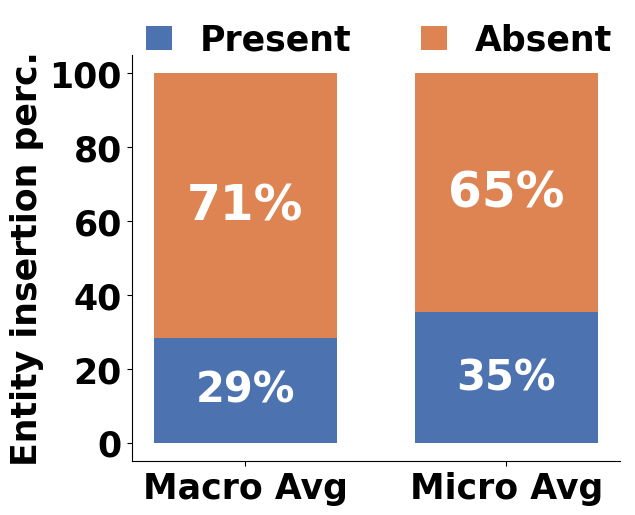

In [109]:
for lang in languages:
    if languages[lang]['total_clean'] < 1_000:
        languages[lang]['total_text'] = languages[lang]['total_clean']
    elif languages[lang]['total_clean'] < 1_000_000:
        languages[lang]['total_text'] = f'{round(languages[lang]["total_clean"] / 1_000):d}K'
    else:
        languages[lang]['total_text'] = f'{round(languages[lang]["total_clean"] / 1_000_000):d}M'

# matplotlib stacked bar plot
import matplotlib.patheffects as path_effects
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc,rcParams
palette = sns.color_palette('deep')
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
line_width=5; alpha_marker = 0.8; alpha_line = 0.7; ms_scatter=100


fig, axs = plt.subplots(1, 1)

# prepare y axis
axs.set_ylabel('Entity insertion perc.', fontsize=25, weight='bold')
axs.set_ylim(-5, 105)
axs.tick_params(axis='y', which='major', labelsize=25)
axs.set_yticks(np.arange(0, 101, 20))
axs.set_yticklabels(np.arange(0, 101, 20), fontsize=25, weight='bold')

# prepare x axis
labels = ['Macro Avg', 'Micro Avg']
axs.set_xticks(np.arange(len(labels)))
axs.set_xticklabels(labels, rotation=0, fontsize=25, weight='bold')

mention_present = []
mention_absent = []

total = {'mention_present': 0,
         'mention_absent': 0,
         'total': 0}
for language in languages:
    mention_present.append(languages[language]['present_text'])
    mention_absent.append(languages[language]['missing_mention'] + languages[language]['missing_sentence'] + languages[language]['missing_span'] + languages[language]['missing_section'])
    total['mention_present'] += languages[language]['present_text'] * languages[language]['total_clean'] / 100
    total['mention_absent'] += (languages[language]['missing_mention'] + languages[language]['missing_sentence'] + languages[language]['missing_span'] + languages[language]['missing_section']) * languages[language]['total_clean'] / 100
    total['total'] += languages[language]['total_clean']

# write micro average results
mention_present.append(total['mention_present'] / total['total'] * 100)
mention_absent.append(total['mention_absent'] / total['total'] * 100)

# write macro average results
mention_present.append(sum(mention_present[:-1]) / len(mention_present[:-1]))
mention_absent.append(sum(mention_absent[:-1]) / len(mention_absent[:-1]))

mention_present = mention_present[-2:]
mention_absent = mention_absent[-2:]

bottom = np.zeros(len(mention_present))
mention_present = np.array(mention_present)
mention_absent = np.array(mention_absent)

# use a colorblind friendly palette
axs.bar(np.arange(len(mention_present)), mention_present, label='Present', bottom=bottom, width=0.7, color=palette[0])
bottom += mention_present
axs.bar(np.arange(len(mention_present)), mention_absent, label='Absent', bottom=bottom, width=0.7, color=palette[1])

# add legend to figure
# only show the legend for the first subplot
# make the legend horizontal and centered
handles, labels = axs.get_legend_handles_labels()
# fig.legend(handles=handles, labels=labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.2), prop={'weight':'bold', 'size':35})
fig.legend(handles=handles, labels=labels, prop={'weight':'bold', 'size':25}, loc='upper center', bbox_to_anchor=(0.6, 1.1), frameon=False, ncols=2, handlelength=0.75)


for i, v in enumerate(mention_present):
    if v > 0:
        axs.text(i, v/2, f'{v:.0f}%', color='white', ha='center', va='center', fontweight='bold', fontsize=30)
for i, v in enumerate(mention_absent):
    if v > 0:
        axs.text(i, mention_present[i]+v/2, f'{v:.0f}%', color='white', ha='center', va='center', fontweight='bold', fontsize=35)
plt.tight_layout()
# save to pdf
plt.savefig('mention_insertion.pdf', bbox_inches='tight')
plt.show()

## 21 languages for 09/23 -> 10/23 and 10/23 -> 11/23

In [6]:
languages = {'af': {'09': {}, '10': {}},
             'cs': {'09': {}, '10': {}},
             'cy': {'09': {}, '10': {}},
             'en': {'09': {}, '10': {}},
             'fr': {'09': {}, '10': {}},
             'ga': {'09': {}, '10': {}},
             'gu': {'09': {}, '10': {}},
             'hi': {'09': {}, '10': {}},
             'is': {'09': {}, '10': {}},
             'it': {'09': {}, '10': {}},
             'ja': {'09': {}, '10': {}},
             'kk': {'09': {}, '10': {}},
             'kn': {'09': {}, '10': {}},
             'ms': {'09': {}, '10': {}},
             'ps': {'09': {}, '10': {}},
             'pt': {'09': {}, '10': {}},
             'simple': {'09': {}, '10': {}},
             'sk': {'09': {}, '10': {}},
             'sw': {'09': {}, '10': {}},
             'ur': {'09': {}, '10': {}},
             'uz': {'09': {}, '10': {}},
            }

In [8]:
for language in languages:
    for month in languages[language]:
        languages[language][month]['total_dirty'] = 0
        languages[language][month]['missing_context'] = 0
        languages[language][month]['missing_negative_contexts'] = 0
        languages[language][month]['bad_target'] = 0
        languages[language][month]['missing_section'] = 0
        languages[language][month]['total_clean'] = 0
        languages[language][month]['total_clean_eval'] = 0 # also excluding the missing section because our model doesn't apply to that
        languages[language][month]['present_text'] = 0
        languages[language][month]['missing_mention'] = 0
        languages[language][month]['missing_sentence'] = 0
        languages[language][month]['missing_span'] = 0
        languages[language][month]['missing_section'] = 0
        languages[language][month]['candidates'] = []

language_keys = list(languages.keys())
for language in (pbar := tqdm(language_keys)):
    for month in languages[language]:
        if not os.path.exists(f'/dlabdata1/tsoares/wikidumps/{language}wiki-NS0-2023{month}01/eval/test_data.parquet'):
            # del languages[language]
            continue
        good_pages = []
        files = glob(f'/dlabdata1/tsoares/wikidumps/{language}wiki-NS0-2023{month}01/processed_data/good_pages/*.parquet') + \
                glob(f'/dlabdata1/tsoares/wikidumps/{language}wiki-NS0-2023{int(month)+1}01/processed_data/good_pages/*.parquet')
        for i, file in enumerate(files):
            pbar.set_description(f'{language} - {i} / {len(files)}')
            try:
                df = pd.read_parquet(file, columns=['title'])
                good_pages.extend(list(df['title'].values))
            except:
                pass
        good_pages = set(good_pages)
        languages[language][month]['good_pages'] = good_pages
        # read test data in chunks
        # only read columns: context, negative_contexts, target_title, missing_category
        parquet_file = pq.ParquetFile(f'/dlabdata1/tsoares/wikidumps/{language}wiki-NS0-2023{month}01/eval/test_data.parquet')
        num_rows = parquet_file.metadata.num_rows
        for batch in parquet_file.iter_batches(batch_size=10_000):
            pbar.set_description(f'{language} - {languages[language][month]["total_dirty"]} / {num_rows}')
            df = batch.to_pandas()
            
            languages[language][month]['total_dirty'] += len(df)
            
            no_context = df['context'] == ''
            languages[language][month]['missing_context'] += no_context.sum()
            
            no_neg_contexts = df['negative_contexts'] == '[]'
            languages[language][month]['missing_negative_contexts'] += no_neg_contexts.sum()
            
            bad_target = ~df['target_title'].isin(languages[language][month]['good_pages'])
            languages[language][month]['bad_target'] += bad_target.sum()

            df_clean = df[~no_context & ~no_neg_contexts & ~bad_target]
            languages[language][month]['total_clean'] += len(df_clean)
            languages[language][month]['total_clean_eval'] += len(df_clean[df_clean['missing_category'] != 'missing_section'])
            
            # find the value counts for column "missing category"
            # include NA values
            categories = df_clean['missing_category'].value_counts(dropna=False)
            languages[language][month]['present_text'] += categories[None] if None in categories.index else 0
            languages[language][month]['missing_mention'] += categories['missing_mention'] if 'missing_mention' in categories.index else 0
            languages[language][month]['missing_sentence'] += categories['missing_sentence'] if 'missing_sentence' in categories.index else 0
            languages[language][month]['missing_span'] += categories['missing_span'] if 'missing_span' in categories.index else 0
            languages[language][month]['missing_section'] += categories['missing_section'] if 'missing_section' in categories.index else 0
            languages[language][month]['candidates'].extend(df_clean['negative_contexts'].reset_index(drop=True).apply(lambda x: x.count("'context'") + 1).values.tolist())

        languages[language][month]['present_text'] /= languages[language][month]['total_clean'] / 100
        languages[language][month]['missing_mention'] /= languages[language][month]['total_clean'] / 100
        languages[language][month]['missing_sentence'] /= languages[language][month]['total_clean'] / 100
        languages[language][month]['missing_span'] /= languages[language][month]['total_clean'] / 100
        languages[language][month]['missing_section'] /= languages[language][month]['total_clean'] / 100

cs - 21 / 22:   5%|▍         | 1/21 [00:08<01:57,  5.87s/it] 

uz - 0 / 5942: 100%|██████████| 21/21 [41:51<00:00, 119.60s/it]        


### Plot link insertion distribution

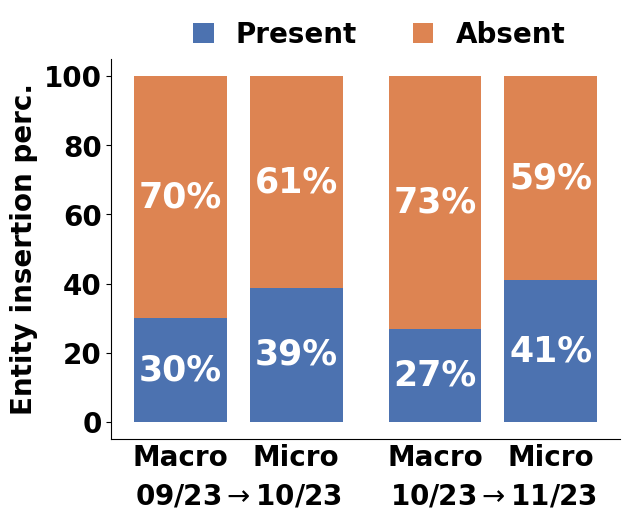

In [31]:
import matplotlib.patheffects as path_effects
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc,rcParams
palette = sns.color_palette('deep')
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
line_width=5; alpha_marker = 0.8; alpha_line = 0.7; ms_scatter=100
fig, axs = plt.subplots(1, 1)

# prepare y axis
axs.set_ylabel('Entity insertion perc.', fontsize=20, weight='bold')
axs.set_ylim(-5, 105)
axs.tick_params(axis='y', which='major', labelsize=20)
axs.set_yticks(np.arange(0, 101, 20))
axs.set_yticklabels(np.arange(0, 101, 20), fontsize=20, weight='bold')

# prepare x axis
xticks = [0, 0.5, 1, 2.2, 2.7, 3.2]
bar_positions = [0, 1, 2.2, 3.2]
labels = ['Macro', '09/23$\\rightarrow$10/23', 'Micro', 'Macro', '10/23$\\rightarrow$11/23', 'Micro']
axs.set_xticks(xticks)
axs.set_xticklabels(labels, rotation=0, fontsize=20, weight='bold')
# vertical alignment of xtick labels
va = [0, -0.1, 0, 0, -0.1, 0]
for t, y in zip(axs.get_xticklabels(), va):
    t.set_y(y)
# remove xticks
axs.tick_params(axis='x', which='major', length=0)


mention_present = {'09': [], '10': []}
mention_absent = {'09': [], '10': []}

total = {'09': {'mention_present': 0,
                'mention_absent': 0,
                'total': 0},
         '10': {'mention_present': 0,
                'mention_absent': 0,
                'total': 0}}
for language in languages:
    for month in languages[language]:
        mention_present[month].append(languages[language][month]['present_text'])
        mention_absent[month].append(languages[language][month]['missing_mention'] + languages[language][month]['missing_sentence'] + languages[language][month]['missing_span'] + languages[language][month]['missing_section'])
        total[month]['mention_present'] += languages[language][month]['present_text'] * languages[language][month]['total_clean'] / 100
        total[month]['mention_absent'] += (languages[language][month]['missing_mention'] + languages[language][month]['missing_sentence'] + languages[language][month]['missing_span'] + languages[language][month]['missing_section']) * languages[language][month]['total_clean'] / 100
        total[month]['total'] += languages[language][month]['total_clean']

# write micro average results
for month in total:
    mention_present[month].append(total[month]['mention_present'] / total[month]['total'] * 100)
    mention_absent[month].append(total[month]['mention_absent'] / total[month]['total'] * 100)

    # write macro average results
    mention_present[month].append(sum(mention_present[month][:-1]) / len(mention_present[month][:-1]))
    mention_absent[month].append(sum(mention_absent[month][:-1]) / len(mention_absent[month][:-1]))

    mention_present[month] = mention_present[month][-2:]
    mention_absent[month] = mention_absent[month][-2:]

# flatten the dictionaries
mention_present = mention_present['09'] + mention_present['10']
mention_absent = mention_absent['09'] + mention_absent['10']

bottom = np.zeros(len(mention_present))
mention_present = np.array(mention_present)
mention_absent = np.array(mention_absent)

# use a colorblind friendly palette
axs.bar(bar_positions, mention_present, label='Present', bottom=bottom, width=0.8, color=palette[0])
bottom += mention_present
axs.bar(bar_positions, mention_absent, label='Absent', bottom=bottom, width=0.8, color=palette[1])

# add legend to figure
# only show the legend for the first subplot
# make the legend horizontal and centered
handles, labels = axs.get_legend_handles_labels()
# fig.legend(handles=handles, labels=labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.2), prop={'weight':'bold', 'size':35})
fig.legend(handles=handles, labels=labels, prop={'weight':'bold', 'size':20}, loc='upper center', bbox_to_anchor=(0.6, 1.1), frameon=False, ncols=2, handlelength=0.75)


for index, (i, v) in enumerate(zip(bar_positions, mention_present)):
    if v > 0:
        axs.text(i, v/2, f'{v:.0f}%', color='white', ha='center', va='center', fontweight='bold', fontsize=25)
for index, (i, v) in enumerate(zip(bar_positions, mention_absent)):
    if v > 0:
        axs.text(i, mention_present[index]+v/2, f'{v:.0f}%', color='white', ha='center', va='center', fontweight='bold', fontsize=25)
plt.tight_layout()
# save to pdf
plt.savefig('mention_insertion.pdf', bbox_inches='tight')
plt.show()

## Plot number of candidates

In [61]:
languages

{'af': {'total_dirty': 1742,
  'missing_context': 270,
  'missing_negative_contexts': 30,
  'bad_target': 2,
  'missing_section': 15.665976535541752,
  'total_clean': 1449,
  'total_clean_eval': 1222,
  'present_text': 47.96411318150449,
  'missing_mention': 7.17736369910283,
  'missing_sentence': 11.11111111111111,
  'missing_span': 18.08143547273982,
  'candidates': [346,
   346,
   347,
   66,
   70,
   88,
   103,
   73,
   72,
   72,
   75,
   75,
   22,
   77,
   77,
   77,
   77,
   84,
   83,
   86,
   95,
   88,
   94,
   94,
   91,
   77,
   93,
   93,
   90,
   94,
   104,
   104,
   45,
   96,
   42,
   42,
   42,
   42,
   29,
   29,
   25,
   21,
   21,
   21,
   21,
   4,
   9,
   9,
   53,
   58,
   52,
   54,
   49,
   5,
   33,
   50,
   58,
   58,
   36,
   36,
   68,
   68,
   66,
   13,
   38,
   38,
   29,
   45,
   45,
   45,
   45,
   40,
   40,
   35,
   39,
   39,
   38,
   38,
   50,
   49,
   36,
   36,
   36,
   35,
   35,
   35,
   35,
   34,
   34,
   33,

  0%|          | 0/106 [00:00<?, ?it/s]

100%|██████████| 107/107 [00:00<00:00, 1580.00it/s]


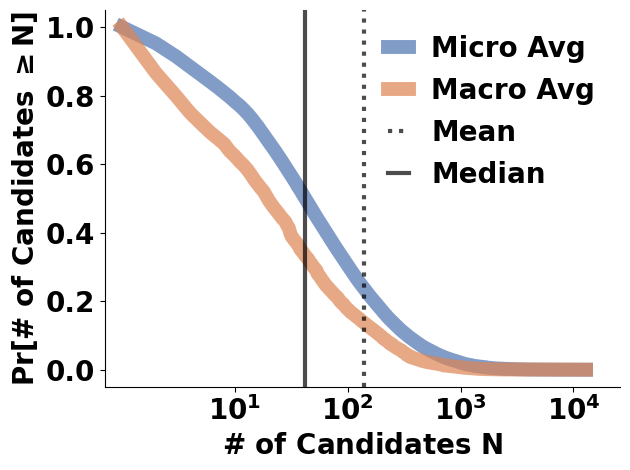

In [11]:
# plot CCDF of number of candidates for English
max_candidates = 0
for lang in languages:
    max_candidates = max(max_candidates, max(languages[lang]['candidates']))

freqs = {lang: {'freqs': [0] * max_candidates, 'total': 0} for lang in languages}
freqs['full'] = {'freqs': [0] * max_candidates, 'total': 0}
for lang in tqdm(languages):
    for candidate in languages[lang]['candidates']:
        if candidate == 0:
            continue
        freqs[lang]['freqs'][candidate - 1] += 1
        freqs[lang]['total'] += 1
        freqs['full']['freqs'][candidate - 1] += 1
        freqs['full']['total'] += 1
        
cumsums = {lang: {'cumsum': None, 'total': None} for lang in freqs}
for lang in tqdm(freqs):
    cumsums[lang]['cumsum'] = np.cumsum(freqs[lang]['freqs'])
    cumsums[lang]['total'] = freqs[lang]['total']

cumsum_microaverage = cumsums['full']['cumsum'] / cumsums['full']['total']
cumsum_macroaverage = np.zeros(len(cumsum_microaverage))
for lang in languages:
    cumsum_macroaverage += cumsums[lang]['cumsum'] / cumsums[lang]['total']
cumsum_macroaverage /= len(languages)

fig, axs = plt.subplots(1, 1)
axs.plot(np.arange(1, len(cumsum_microaverage[:-1]) + 1), 1 - cumsum_microaverage[:-1], label='Micro Avg', color=palette[0], linewidth=line_width, alpha=alpha_line)
axs.plot(np.arange(1, len(cumsum_macroaverage[:-1]) + 1), 1 - cumsum_macroaverage[:-1], label='Macro Avg', color=palette[1], linewidth=line_width, alpha=alpha_line)

# format x axis
axs.set_xscale('log')
axs.set_xticks([10, 100, 1000, 10000])
axs.set_xticklabels(['$\mathbf{10^1}$', '$\mathbf{10^2}$', '$\mathbf{10^3}$', '$\mathbf{10^4}$'], fontsize=20)
axs.set_xlabel('# of Candidates $\mathbf{N}$', fontsize=20, weight='bold')
axs.tick_params(axis='x', which='minor', bottom=False)
axs.set_xlim(0.7, max_candidates * 2)

# format y axis
# axs.set_yscale('log')
axs.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
axs.set_yticklabels(['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=20, weight='bold')
axs.set_ylabel('Pr[# of Candidates $\mathbf{\geq N}$]', fontsize=20, weight='bold')
axs.set_ylim(-0.05, 1.05)

# add mean and median lines
flat_freqs = []
for i in range(len(freqs['full']['freqs'])):
    flat_freqs.extend([i + 1] * freqs['full']['freqs'][i])
mean = np.mean(flat_freqs)
median = np.median(flat_freqs)

axs.axvline(mean, color='black', linestyle='dotted', linewidth=3, alpha=alpha_line, label='Mean')
axs.axvline(median, color='black', linestyle='-', linewidth=3, alpha=alpha_line, label='Median')


# set legend
handles, labels = axs.get_legend_handles_labels()
# axs.legend(handles=handles, labels=labels, loc='upper center', ncol=2, fontsize=20, bbox_to_anchor=(0.5, 1.2), prop={'weight':'bold', 'size':20}, frameon=False)
axs.legend(handles=handles, labels=labels, prop={'weight': 'bold', 'size': 20}, frameon=False, handlelength=0.75)
    

plt.tight_layout()
plt.savefig('candidate_ccdf.pdf', bbox_inches='tight')
plt.show()

In [135]:
1 - cumsum_microaverage[10000]

7.151906493918503e-06

## Plot page sparsity as a function of active editors

In [5]:
files = glob('/dlabdata1/tsoares/wikidumps/*wiki-NS0-20231001/eval/test_data.parquet')
# find the list of all languages
languages = [file.split('/')[-3][:-17] for file in files]
languages.sort()
languages = {lang: {} for lang in languages}
len(languages)

106

In [6]:
df = pd.read_html('https://commons.wikimedia.org/wiki/Data:Wikipedia_statistics/data.tab')[0]
df

site activeusers admins   articles       edits  \
                    string      number number     number      number   
                      site activeusers admins   articles       edits   
0             aa.wikipedia           1      1          0        4685   
1            aa.wiktionary           1      1          0        6805   
2             aa.wikibooks           1      1          0        3421   
3             ab.wikipedia          35      2       6141      134868   
4            ab.wiktionary           1      1          0        8982   
..                     ...         ...    ...        ...         ...   
931  totalclosed.wikipedia          29     14         30      310684   
932   totalclosed.wikinews           6      5       2151      340723   
933  totalclosed.wikiquote          16     28        638      136020   
934  totalclosed.wikibooks          41     55        671      195656   
935              total.all      369835   5756  318576293  6824376361   

         files      pages      users  
        number     number     number  
         files      pages      users  
0            0        508       4066  
1            0        101        585  
2            0         79        719  
3            9      24401      20260  
4            0        248        589  
..         ...        ...        ...  
931          0       5984      57802  
932         11      23583      11928  
933          6       9578      14337  
934        236      10439      28599  
935  105745017  608856252  204389334  

[936 rows x 8 columns]

In [7]:
# df has indexes like ('site', 'string', 'site'). Reduce so it only has one index, 'site'
df.columns = df.columns.droplevel(1)
df.columns = df.columns.droplevel(1)
df

site  activeusers  admins   articles       edits  \
0             aa.wikipedia            1       1          0        4685   
1            aa.wiktionary            1       1          0        6805   
2             aa.wikibooks            1       1          0        3421   
3             ab.wikipedia           35       2       6141      134868   
4            ab.wiktionary            1       1          0        8982   
..                     ...          ...     ...        ...         ...   
931  totalclosed.wikipedia           29      14         30      310684   
932   totalclosed.wikinews            6       5       2151      340723   
933  totalclosed.wikiquote           16      28        638      136020   
934  totalclosed.wikibooks           41      55        671      195656   
935              total.all       369835    5756  318576293  6824376361   

         files      pages      users  
0            0        508       4066  
1            0        101        585  
2            0         79        719  
3            9      24401      20260  
4            0        248        589  
..         ...        ...        ...  
931          0       5984      57802  
932         11      23583      11928  
933          6       9578      14337  
934        236      10439      28599  
935  105745017  608856252  204389334  

[936 rows x 8 columns]

In [9]:
# data variant with links/page
import pyarrow.parquet as pq
sparsity_stats = {lang: {'links': 0, 'pages': 0, 'editors': 0} for lang in languages}
for lang in sparsity_stats:
    sparsity_stats[lang]['editors'] = df[df['site'] == f'{lang}.wikipedia']['activeusers'].values[0]
for lang in (pbar := tqdm(sparsity_stats)):
    files = glob(f'/dlabdata1/tsoares/wikidumps/{lang}wiki-NS0-20231001/processed_data/pages/')
    for i, file in enumerate(files):
        pbar.set_description(f'{lang} - {i} / {len(files)} - pages')
        table = pq.read_table(file, columns=[])
        sparsity_stats[lang]['pages'] += table.num_rows
    
    files = glob(f'/dlabdata1/tsoares/wikidumps/{lang}wiki-NS0-20231001/processed_data/links')
    for i, file in enumerate(files):
        pbar.set_description(f'{lang} - {i} / {len(files)} - links')
        table = pq.read_table(file, columns=[])
        sparsity_stats[lang]['links'] += table.num_rows

for lang in sparsity_stats:
    sparsity_stats[lang]['density'] = sparsity_stats[lang]['links'] / sparsity_stats[lang]['pages']
sparsity_stats

af - 0 / 1 - links:   0%|          | 0/106 [00:00<?, ?it/s]

zh - 0 / 1 - links: 100%|██████████| 106/106 [01:48<00:00,  1.03s/it]   


{'af': {'links': 1413841,
  'pages': 111582,
  'editors': 195,
  'density': 12.67086985356061},
 'am': {'links': 92001,
  'pages': 15772,
  'editors': 56,
  'density': 5.833185391833629},
 'an': {'links': 865053,
  'pages': 44163,
  'editors': 77,
  'density': 19.587731811697576},
 'ar': {'links': 17535443,
  'pages': 1219534,
  'editors': 3734,
  'density': 14.378806166945735},
 'ary': {'links': 51254,
  'pages': 7213,
  'editors': 57,
  'density': 7.105781228337723},
 'as': {'links': 108836,
  'pages': 12301,
  'editors': 119,
  'density': 8.847735956426307},
 'ast': {'links': 2934909,
  'pages': 133291,
  'editors': 125,
  'density': 22.018808471689763},
 'az': {'links': 2774088,
  'pages': 196588,
  'editors': 705,
  'density': 14.111176674059454},
 'azb': {'links': 1143019,
  'pages': 243417,
  'editors': 113,
  'density': 4.695723799077304},
 'ba': {'links': 1019373,
  'pages': 63291,
  'editors': 72,
  'density': 16.106128833483435},
 'bar': {'links': 220153,
  'pages': 27067,
 

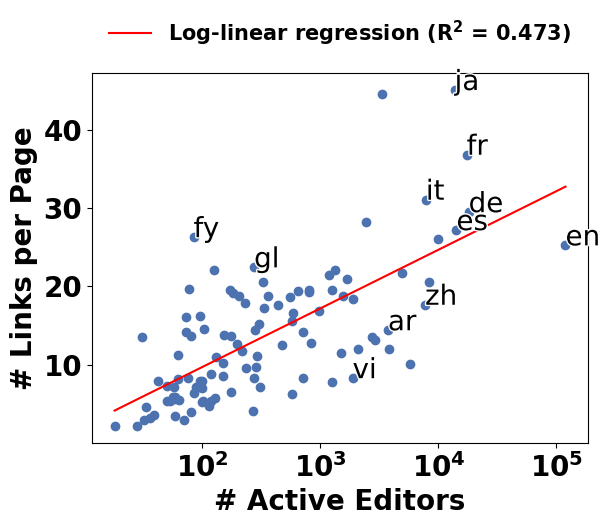

In [13]:
# do a log-linear regression
from scipy.stats import linregress
x = [sparsity_stats[lang]['editors'] for lang in sparsity_stats]
y = [sparsity_stats[lang]['density'] for lang in sparsity_stats]
# sort them jointly by x
x, y = zip(*sorted(zip(x, y)))
x = np.log(x)
slope, intercept, r_value, p_value, std_err = linregress(x, y)
plt.plot(np.exp(x), slope * x + intercept, color='red', label='Log-linear regression ($\mathbf{R^2}$ = ' + f'{r_value**2:.3f})')
plt.scatter([sparsity_stats[lang]['editors'] for lang in sparsity_stats], [sparsity_stats[lang]['density'] for lang in sparsity_stats], color=palette[0])
plt.legend(prop={'size': 15, 'weight': 'bold'}, bbox_to_anchor=(0.5, 1.2), loc='upper center', frameon=False)
# set xlog scale
plt.xscale('log')

# format x axis
plt.xticks([1e2, 1e3, 1e4, 1e5], ['$\mathbf{10^2}$', '$\mathbf{10^3}$', '$\mathbf{10^4}$', '$\mathbf{10^5}$'], fontsize=20)
plt.xlabel('# Active Editors', fontsize=20, weight='bold')
plt.tick_params(axis='x', which='minor', bottom=False)

# format y axis
plt.ylabel('# Links per Page', fontsize=20, weight='bold')
# set the y ticks to bold and fontsize 20
plt.yticks(fontsize=20, weight='bold')

# print the language code next to the dot for some languages
# surround text with white border
for lang in ['en', 'de', 'es', 'fr', 'it', 'ja', 'zh', 'vi', 'ar', 'fy', 'gl']:
    plt.text(sparsity_stats[lang]['editors'], sparsity_stats[lang]['density'], lang, fontsize=20, color='black', path_effects=[path_effects.Stroke(linewidth=2, foreground='white'), path_effects.Normal()])
plt.savefig('sparsity.pdf', bbox_inches='tight') 
plt.show()

In [14]:
# data variant with added links
import pyarrow.parquet as pq
sparsity_stats = {lang: {'added_links': 0, 'editors': 0} for lang in languages}
for lang in sparsity_stats:
    sparsity_stats[lang]['editors'] = df[df['site'] == f'{lang}.wikipedia']['activeusers'].values[0]
for lang in (pbar := tqdm(sparsity_stats)):
    table = pq.read_table(f'/dlabdata1/tsoares/wikidumps/{lang}wiki-NS0-20231001/eval/test_data.parquet', columns=[])
    sparsity_stats[lang]['added_links'] += table.num_rows
sparsity_stats

  0%|          | 0/106 [00:00<?, ?it/s]

100%|██████████| 106/106 [00:01<00:00, 55.15it/s]


{'af': {'added_links': 1742, 'editors': 195},
 'am': {'added_links': 25, 'editors': 56},
 'an': {'added_links': 99, 'editors': 77},
 'ar': {'added_links': 22544, 'editors': 3734},
 'ary': {'added_links': 135, 'editors': 57},
 'as': {'added_links': 587, 'editors': 119},
 'ast': {'added_links': 51, 'editors': 125},
 'az': {'added_links': 7224, 'editors': 705},
 'azb': {'added_links': 35, 'editors': 113},
 'ba': {'added_links': 735, 'editors': 72},
 'bar': {'added_links': 22, 'editors': 62},
 'be': {'added_links': 3736, 'editors': 304},
 'bg': {'added_links': 5595, 'editors': 806},
 'br': {'added_links': 1459, 'editors': 99},
 'bs': {'added_links': 1229, 'editors': 180},
 'ca': {'added_links': 26779, 'editors': 1173},
 'ce': {'added_links': 483, 'editors': 53},
 'cs': {'added_links': 15117, 'editors': 2453},
 'cv': {'added_links': 530, 'editors': 58},
 'cy': {'added_links': 455, 'editors': 130},
 'da': {'added_links': 2887, 'editors': 803},
 'de': {'added_links': 107520, 'editors': 18023}

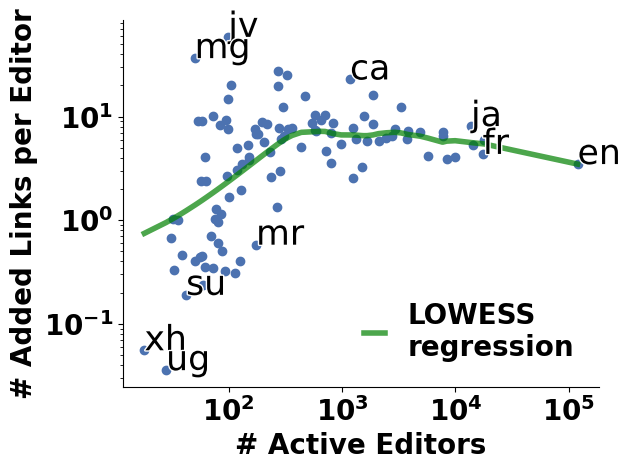

In [112]:
# do a lowess regression
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

from scipy.stats import linregress
x = [sparsity_stats[lang]['editors'] for lang in sparsity_stats]
y = [sparsity_stats[lang]['added_links'] / sparsity_stats[lang]['editors'] for lang in sparsity_stats]
# sort them jointly by x
x, y = zip(*sorted(zip(x, y)))
# x = np.log(x)
x = np.array(x)
# do the lowess regression
z = lowess(y, x, frac=0.7)
plt.plot(x, z[:, 1], color='green', label='LOWESS\nregression', linewidth=4, alpha=alpha_line)


# slope, intercept, r_value, p_value, std_err = linregress(x, y)
# plt.plot(x, slope * x + intercept, color='red', label='Linear regression ($\mathbf{R^2}$ = ' + f'{r_value**2:.3f})')
plt.scatter([sparsity_stats[lang]['editors'] for lang in sparsity_stats], [sparsity_stats[lang]['added_links'] / sparsity_stats[lang]['editors'] for lang in sparsity_stats], color=palette[0])
plt.legend(prop={'size': 20, 'weight': 'bold'}, frameon=False, handlelength=0.75)

# format x axis
plt.xscale('log')
plt.xticks(fontsize=20, weight='bold')
plt.xlabel('# Active Editors', fontsize=20, weight='bold')
plt.tick_params(axis='x', which='minor', bottom=False)

# format y axis
plt.yscale('log')
plt.ylabel('# Added Links per Editor', fontsize=20, weight='bold')
plt.yticks(fontsize=20, weight='bold')

# print the language code next to the dot for some languages
# surround text with white border
for lang in ['en', 'fr', 'xh', 'su', 'ug', 'jv', 'mg', 'ja', 'ca', 'mr']:
    plt.text(sparsity_stats[lang]['editors'], sparsity_stats[lang]['added_links'] / sparsity_stats[lang]['editors'], lang, fontsize=25, color='black', path_effects=[path_effects.Stroke(linewidth=2, foreground='white'), path_effects.Normal()])
plt.tight_layout()
plt.savefig('added_links.pdf', bbox_inches='tight') 
plt.show()

In [77]:
for i in range(len(y)):
    print(x[i], y[i])

18 0.05555555555555555
28 0.03571428571428571
31 0.6774193548387096
32 1.03125
33 0.3333333333333333
36 1.0
39 0.46153846153846156
42 0.19047619047619047
50 0.4
50 36.68
53 9.11320754716981
56 0.44642857142857145
57 2.3684210526315788
58 0.4482758620689655
58 9.137931034482758
59 0.23728813559322035
62 0.3548387096774194
62 4.064516129032258
63 2.4126984126984126
70 0.7
72 10.208333333333334
73 0.3424657534246575
75 1.0266666666666666
77 1.2857142857142858
80 0.6
80 0.9625
84 8.25
85 1.1411764705882352
88 0.5
93 0.3225806451612903
95 9.305263157894737
96 2.6666666666666665
99 7.545454545454546
99 14.737373737373737
99 58.81818181818182
101 1.6633663366336633
104 20.221153846153847
113 0.30973451327433627
119 3.042016806722689
119 4.932773109243698
125 0.408
127 1.9448818897637796
130 3.5
149 5.261744966442953
150 3.84
152 4.052631578947368
170 7.6647058823529415
174 0.5804597701149425
175 6.857142857142857
180 6.8277777777777775
195 8.933333333333334
206 5.669902912621359
218 8.4357798